In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import copy
from collections import Counter
import time
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#ff0000', '#00ff00', '#0000ff'])

In [2]:
d_train = pd.read_csv("Classification_train.csv")

### Preprocessing

#### Label vs Count

In [3]:
d_train[['label']].value_counts()

label
4        3118
6        3094
5        3018
1        3002
3        2993
9        2990
0        2979
7        2942
8        2936
2        2928
Name: count, dtype: int64

In [4]:
test_index_list = []
for label in range(10):
    df_sub = d_train[d_train.label == label].copy()
    num = df_sub.shape[0]
    test_size = int(0.3 * num)
    test_index = np.random.choice(df_sub.index, size=test_size).tolist()
    
    test_index_list.extend(test_index)

In [5]:
df_train = d_train[~d_train.index.isin(test_index_list)]
df_test = d_train[d_train.index.isin(test_index_list)]

In [6]:
x_train = df_train[[col for col in df_train.columns if col != 'label']].values
y_train = df_train['label'].values
x_test = df_test[[col for col in df_test.columns if col != 'label']].values
y_test = df_test['label'].values

<function matplotlib.pyplot.show(close=None, block=None)>

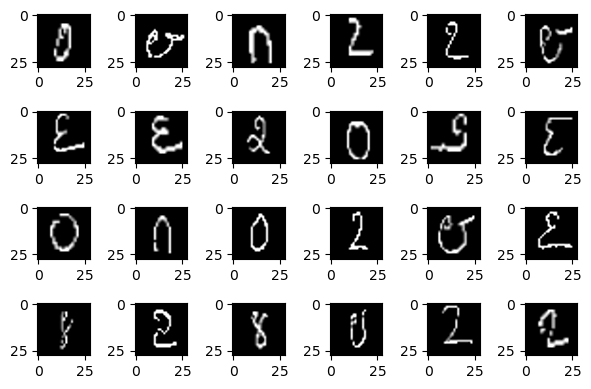

In [7]:
fig,ax=plt.subplots(4,6,figsize=(6,4))
num=0
for i in range(4):
  for j in range(6):
    ax[i][j].imshow(x_train[num].reshape(28,28),interpolation='spline16', cmap = 'gray')
    num+=1
plt.tight_layout()
plt.show

### Implementation

In [27]:
class VectorizedKNN:
    def __init__(self, x_train, y_train, x_test, k=3):
        self.k = k
        self.x_train = x_train
        self.y_train = y_train
        #self.y_test = y_test
        self.x_test = x_test

    def fit(self, X, y):
        self.x_train = X
        self.y_train = y

    def predict_chai(self):
        X = self.x_test
        Y = self.x_train
        dist = np.zeros((X.shape[0], Y.shape[0]))
        dist = (X**2).sum(axis=1)[:, np.newaxis] + (Y**2).sum(axis=1) - 2 * X.dot(Y.T)
        dist_part = np.argpartition(dist, kth=self.k, axis=1)[:,:self.k]
        y_preds_k = np.array([self.y_train[dist_part[:,i]] for i in range(self.k)]) 
        y_preds = np.array([np.argmax(np.bincount(y_preds_k[:,i])) for i in range(y_preds_k.shape[1])])
        return y_preds

In [28]:
knn = VectorizedKNN(x_train, y_train, x_test, 3)
start_time = time.time()
predictions = knn.predict_chai()
end_time = time.time()
print(end_time - start_time)
print("Predictions:", predictions)

655.3046474456787
Predictions: [5 9 6 ... 1 4 9]


In [29]:
y_test

array([5, 9, 6, ..., 1, 4, 9], dtype=int64)

In [30]:
def confusion_matrix(y_true, y_pred, num_classes):
    # Initialize the confusion matrix with zeros
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Flatten the 2D arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate the confusion matrix
    for true_label, pred_label in zip(y_true_flat, y_pred_flat):
        conf_matrix[true_label, pred_label] += 1

    return conf_matrix

In [31]:
confusion_matrix(y_test, predictions, 10)

array([[746,  23,   0,   2,   0,   0,   0,   0,   0,   0],
       [  2, 779,   0,   0,   0,   0,   0,   0,   0,   0],
       [  8,   0, 750,   0,   0,   1,   0,   0,   0,   0],
       [  8,   2,   0, 770,   4,   0,   0,   5,   0,   0],
       [  0,   1,   0,   3, 816,   1,   1,   0,   0,   0],
       [  0,   2,   2,   4,  13, 763,   0,   1,   0,   0],
       [  0,   0,   0,   0,   2,   0, 780,  12,   0,   3],
       [  0,   1,   0,   8,   3,   0,  18, 736,   0,   2],
       [ 16,   0,   0,   0,   0,   0,   0,   0, 725,   0],
       [  0,   0,   0,   0,   4,   0,   2,   1,   0, 773]])

In [32]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_instances = len(y_true)
    accuracy = correct_predictions / total_instances
    return accuracy

In [33]:
Accuracy = calculate_accuracy(y_test, predictions)
print(f'Accuracy: {Accuracy}')

Accuracy: 0.9801103554471962


Test Data

In [34]:
d_test = pd.read_csv("Classification_test.csv")

In [40]:
X_test_g = d_test[d_test.columns.values]
X_test_g = X_test_g.drop(['ID'], axis=1).to_numpy()

In [41]:
knn_test = VectorizedKNN(x_train, y_train, X_test_g, 3)
predictions_tf = knn_test.predict_chai()
print("Predictions:", predictions_tf)

Predictions: [0 4 5 ... 0 8 4]


In [42]:
insert_index = 0
modified_array = np.insert(X_test_g, insert_index, predictions_tf, axis=1)

In [43]:
df = pd.DataFrame(modified_array)
file_path = 'KNN.csv'
df.to_csv(file_path, index=False, header=False)